## Initialization

In [1]:
import pandas as pd
import numpy as np

In [2]:
import compyler as cp

In [3]:
data = pd.read_csv("mfa_test_data")

In [4]:
cols = data.shape[1] // 4

In [5]:
nt = []
nc = []

for i in range(cols):
    offset = i * 4
    t = data.iloc[:, i].sum() + data.iloc[:, i+2].sum()
    c = data.iloc[:, i+1].sum() + data.iloc[:, i+3].sum()
    nt.append(t)
    nc.append(c)
    
nt = np.array(nt)
nc = np.array(nc)

In [6]:
nt

array([156,  38, 160, ...,  14, 175,  23])

In [7]:
nc

array([ 38, 160,  37, ..., 175,  23, 144])

In [8]:
maximum_count = max(max(nt), max(nc))

In [96]:
maximum_count

191

## Approximation of inverse, sqrt, min functions

In [97]:
def inverse(x, d): # 0 < x < 2
    a = -x + 2.0
    b = -x + 1.0
    
    for i in range(d):
        b = b * (b + 0.0)
        a = a * (b + 1.0)
    
    return a

In [98]:
inverse(0.5, 10)

2.0

In [99]:
def sqrt(x, d): # 0 < x < 1
    a = x
    b = x - 1.0
    for i in range(d):
        a = a * (-b * 0.5 + 1.0)
        b = b * (b + 0.0) * (b - 3.0) * 0.25
    return a

In [101]:
sqrt(0.25, 10)

0.5

In [102]:
def min_num(a, b, d): # 0 < a,b < 1
    x = (a + b) * 0.5
    y = (a - b) * 0.5
    
    z = sqrt(y * (y + 0.0), d)
    
    return x - z

In [103]:
min_num(0.5, 0.4, 10)

0.4000234087815619

## $ MAF = min(n(T),n(C)) / (n(T)+n(C)) $

In [89]:
def maf(a, b, maximum_count, d1=5, d2=5):
    a_scaled = a * (0.5 / maximum_count)
    b_scaled = b * (0.5 / maximum_count)
    print(a_scaled)
    print(b_scaled)
    return min_num(a_scaled, b_scaled, d1) * inverse(a_scaled + b_scaled, d2)    

## Compiling the circuit

In [195]:
plan = cp.CKKSplan()

a = plan.add("a", 35,)
b = plan.add("b", 35,)

d = maf(a, b, maximum_count, 7, 7)

(a × 0.002617801047120419)
(b × 0.002617801047120419)


In [196]:
plan.compile(d)

Trimming 13 nodes.
Executing what possible...
Inserting relinearize nodes...
Padding with copies...


In [197]:
plan.get_params()

(32768,
 [60, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40],
 [60])

In [198]:
padding = plan.slots - len(nt)

nt_padded = np.concatenate([nt, np.zeros(padding)])
nc_padded = np.concatenate([nc, np.zeros(padding)])

In [199]:
# Seal computation (encrypted)
seal_maf = plan.seal_compute({"a": nt_padded, "b": nc_padded})

In [200]:
# Plain computation (not exact)
plain_maf = plan.plain_compute({"a": nt_padded, "b": nc_padded})

In [201]:
# Plain computation (exact)
real_maf = np.minimum(nt, nc) / (nt + nc)

In [202]:
import matplotlib.pyplot as plt

In [203]:
order = real_maf.argsort()

Text(0, 0.5, 'MAF abs. error')

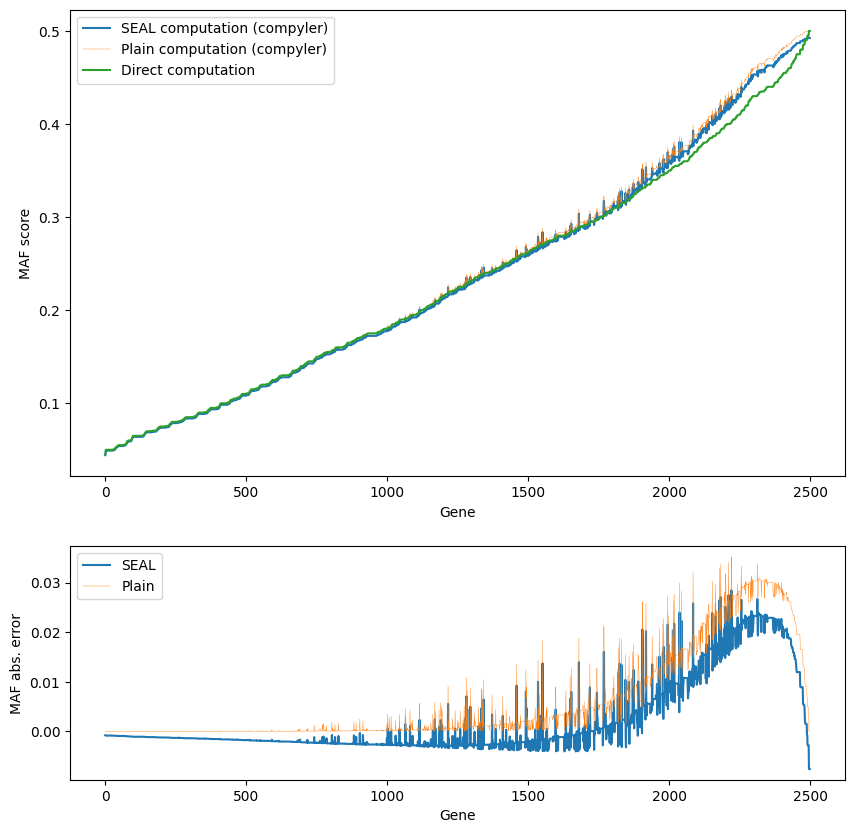

In [204]:
fig, axs = plt.subplots(nrows=2, height_ratios=(8, 4), figsize=(10, 10))

axs[0].plot(seal_maf[0:len(real_maf)][order], label = 'SEAL computation (compyler)')
axs[0].plot(plain_maf[0:len(real_maf)][order], lw=0.3, label = 'Plain computation (compyler)')
axs[0].plot(real_maf[order], label = 'Direct computation')
axs[0].legend()
axs[0].set_xlabel("Gene")
axs[0].set_ylabel("MAF score")

axs[1].plot((seal_maf[0:len(real_maf)] - real_maf)[order], label="SEAL")
axs[1].plot((plain_maf[0:len(real_maf)] - real_maf)[order], lw=0.3, label="Plain")

axs[1].legend()
axs[1].set_xlabel("Gene")
axs[1].set_ylabel("MAF abs. error")
